# Task

The regs.csv table contains the number of user registrations in the system by month until July 2022.

You need to write a Python script that predicts the number of registrations in August 2022.

# Content

 1. [Libraries, opening data, general information, preprocessing](#start)  
     

 2. [Graph, selection of time series components](#plot)

    
 3. [Forecasting](#forecast)

  

<a id='start'></a>
## Libraries, opening data, general information, preprocessing

In [1]:
import pandas as pd
import math
import numpy
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime as datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vROPKT1gT3sweUfWmiV3SCuvEyB5MiuHcOi64eBbHmcqXsDr7uDTh24dzBzXWRbyucbZpSvFB4ejPOt/pub?output=csv'
df = pd.read_csv(path, parse_dates = True, index_col = 'period')
df.head()

,users
period,
2020-06-01,8623
2020-07-01,7904
2020-08-01,8237
2020-09-01,9267
2020-10-01,8868


Временную составляющую переименуем в timestamp, как принято при работе  с временными рядами и отсортируем индекс в порядке возрастания.

In [3]:
df.index.names = ['timestamp']
df = df.sort_index()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2020-06-01 to 2022-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   users   26 non-null     int64
dtypes: int64(1)
memory usage: 416.0 bytes


In [5]:
df.shape

(26, 1)

In [6]:
df.isna().sum()

users    0
dtype: int64

In [7]:
df.duplicated().sum()

0

Пропусков, дубликатов нет. Всего имеем 26 значений за 26 месяцев.

<a id='plot'></a>
## Graph, selection of time series components

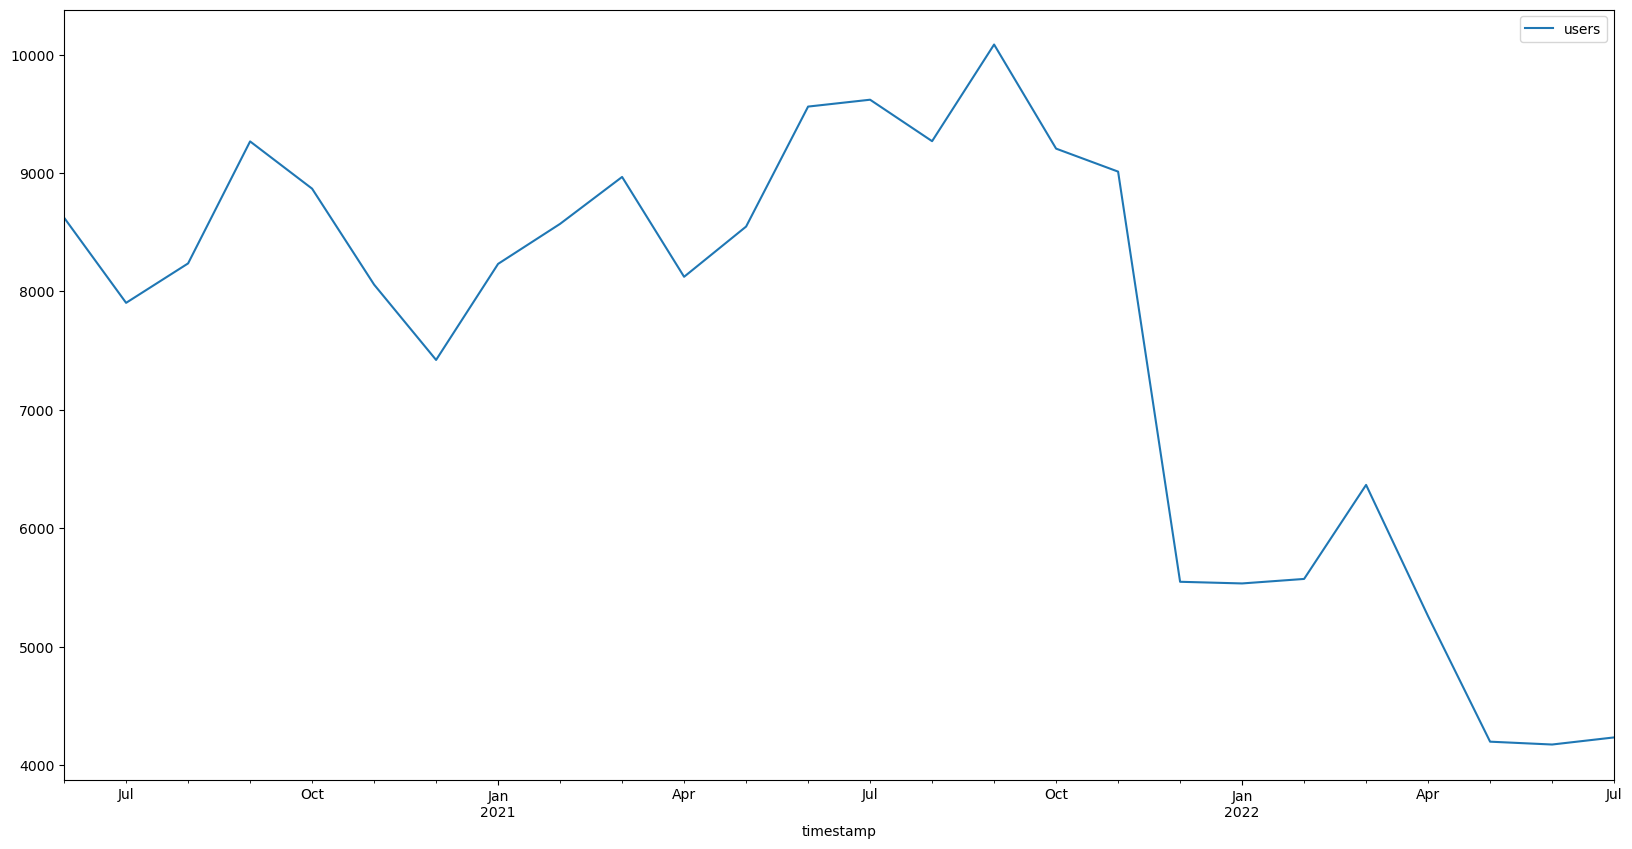

In [8]:
df.plot(figsize = (20,10))
plt.show()

На графике видим явный тренд на снижение  с сентября 2021 года. Скорее всего есть и сезонность. 

Попробуем автоматически выделить из нашего ряда компоненты тренда, сезонности и шум.

In [9]:
res = sm.tsa.seasonal_decompose(df)

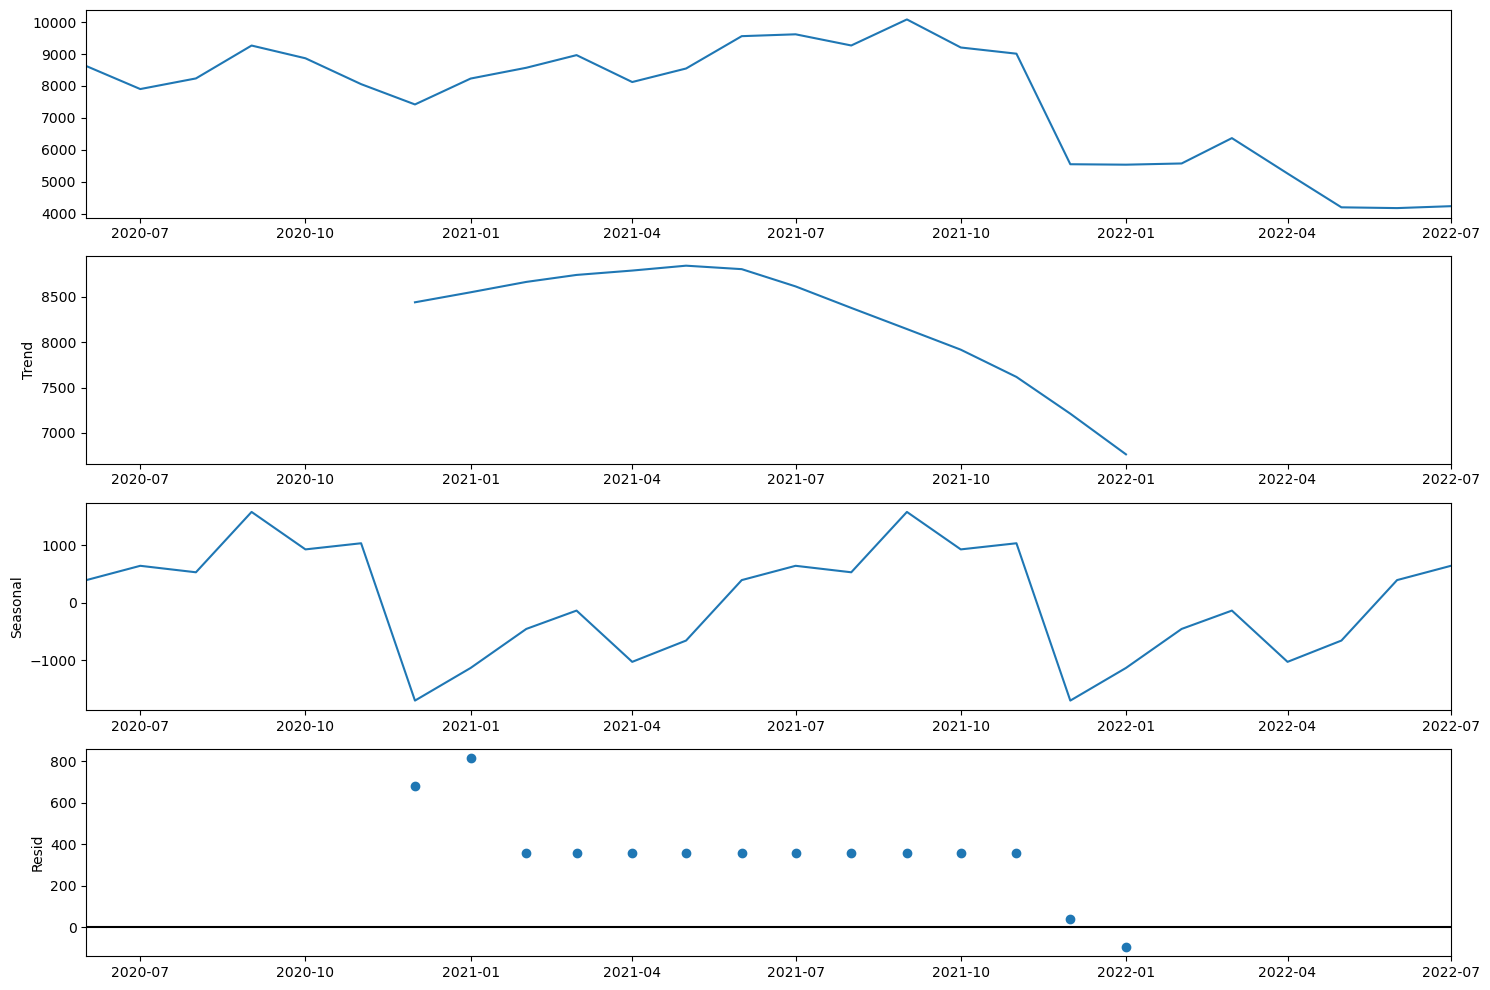

In [10]:
plt.rc('figure', figsize = (15,10))
resplot = res.plot()

Мы  видим в ряде явно выраженный тренд, сезонность (12 месяцев) и довольно приличный шум


<a id='forecast'></a>
## Forecasting

Для прогноза будем использовать тройное экспоненциальное сглаживание Holt-Winters. Оно учитывает и тренд, и сезонность, проще чем SARIMAX. И подходит если у нас небольшой шаг прогнозирования, что как раз является нашим случаем т.к. нам необходим прознозирование на одну точку.

Делить данные на тренировочные, тестовые и валидационные не будем,т.к. у нас их очень мало.

Посмотрим как работает несколько моделей с аддитивной и мультипликативной сезонностью и с учётом затухания тренда.
По графику выше видно, что сезонность у нас 12 месяцев.

In [11]:
fit1 = ExponentialSmoothing(
    df,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated"
).fit()

fit2 = ExponentialSmoothing(
    df,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated"
).fit()

fit3 = ExponentialSmoothing(
    df,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    damped_trend=True,
    initialization_method="estimated"
).fit()

fit4 = ExponentialSmoothing(
    df,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    damped_trend=True,
    initialization_method="estimated"
).fit()

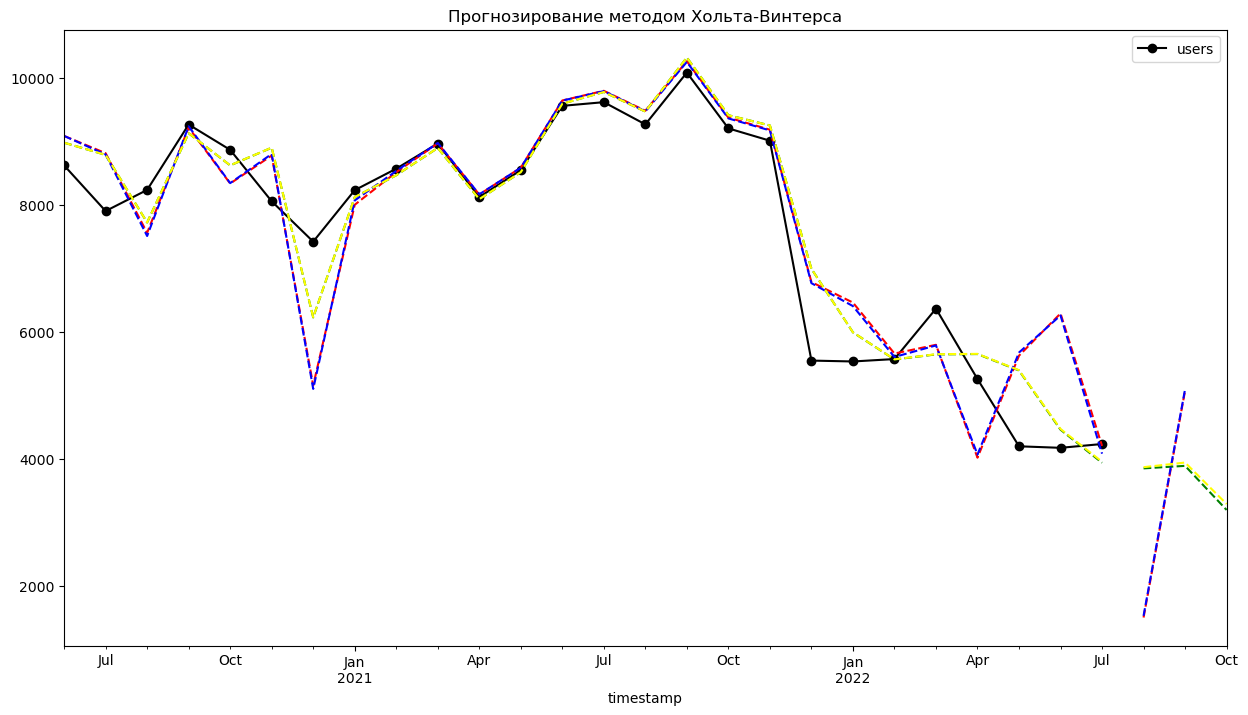

In [12]:
ax = df.plot(
    figsize=(15,8),
    marker="o",
    color="black",
    title="Прогнозирование методом Хольта-Винтерса"
)

fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")
fit3.fittedvalues.plot(ax=ax, style="--", color="blue")
fit4.fittedvalues.plot(ax=ax, style="--", color="yellow")

fit1.forecast(3).plot(ax=ax, style="--", color="red")
fit2.forecast(3).plot(ax=ax, style="--", color="green")
fit3.forecast(3).plot(ax=ax, style="--", color="blue")
fit4.forecast(3).plot(ax=ax, style="--", color="yellow")
plt.show()
print('RMSE1 = ' , mean_squared_error(df, fit1.fittedvalues) ** 0.5)
print('RMSE2 = ' , mean_squared_error(df, fit2.fittedvalues) ** 0.5)
print('RMSE3 = ' , mean_squared_error(df, fit3.fittedvalues) ** 0.5)
print('RMSE4 = ' , mean_squared_error(df, fit4.fittedvalues) ** 0.5)

In [13]:
fit4.forecast(1)

2022-08-01    3870.116052
Freq: MS, dtype: float64

In [14]:
print('RMSE1 = ' , mean_squared_error(df, fit1.fittedvalues) ** 0.5)
print('RMSE2 = ' , mean_squared_error(df, fit2.fittedvalues) ** 0.5)
print('RMSE3 = ' , mean_squared_error(df, fit3.fittedvalues) ** 0.5)
print('RMSE4 = ' , mean_squared_error(df, fit4.fittedvalues) ** 0.5)

RMSE1 =  842.2528556359
RMSE2 =  562.0070003594755
RMSE3 =  843.2589280826799
RMSE4 =  562.0805321820643


Минимальная ошибка у второй модели, с аддитивным трендом, мультипликативной сезонностью и без затухающего тренда.

Добавим наш прогноз в исходную таблицу

In [17]:
df = df.reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  26 non-null     datetime64[ns]
 1   users      26 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 544.0 bytes


In [18]:
df_forecast = pd.DataFrame(fit4.forecast(1))
df_forecast = df_forecast.reset_index()
print('RMSE1 = ' , mean_squared_error(df, fit1.fittedvalues) ** 0.5)
print('RMSE2 = ' , mean_squared_error(df, fit2.fittedvalues) ** 0.5)
print('RMSE3 = ' , mean_squared_error(df, fit3.fittedvalues) ** 0.5)
print('RMSE4 = ' , mean_squared_error(df, fit4.fittedvalues) ** 0.5)

In [20]:
df = df.append(df_forecast, ignore_index = True)

In [21]:
df

,timestamp,users
0,2020-06-01,8623
1,2020-07-01,7904
2,2020-08-01,8237
3,2020-09-01,9267
4,2020-10-01,8868
5,2020-11-01,8058
6,2020-12-01,7422
7,2021-01-01,8233
8,2021-02-01,8571
9,2021-03-01,8967
